In [1]:
from import_data import *
from cleaning import *
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble.partial_dependence import plot_partial_dependence,partial_dependence
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
from model import *
import pickle

In [2]:
now = datetime.datetime.now()
this_year = now.year
this_year

2019

In [3]:
salary = get_data('data/salary.p')
stats = get_data('data/stats.p')
free_agents = get_data('data/free_agents.p')

In [4]:
add_features(stats)
final_data = combine_data(salary,stats,free_agents)
final_data = cleaning(final_data)
dummies_data = pd.get_dummies(final_data,columns=['Type','Pos.'],drop_first=True)
final_data1,fa_this_year = seperate_this_year(dummies_data,this_year)
X = final_data1.drop(['Churn'],axis=1)
y = final_data1['Churn']
X_1, x_val, y_1, y_val = train_test_split(X,y,test_size=0.1)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
nba_reduced,labels = scale_and_split(X_1,y_1)
group0, y0 = split_groups(X_1,y_1,labels,0)
X0_train, X0_test, y0_train, y0_test = train_test_split(group0,y0)
group1, y1 = split_groups(X_1,y_1,labels,1)
X1_train, X1_test, y1_train, y1_test = train_test_split(group1,y1)
group2, y2 = split_groups(X_1,y_1,labels,2)
X2_train, X2_test, y2_train, y2_test = train_test_split(group2,y2)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


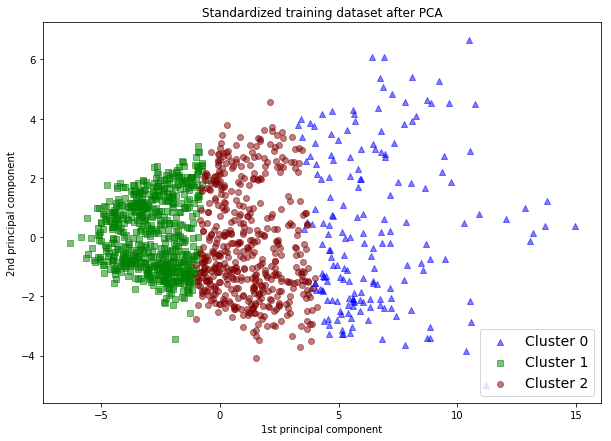

In [6]:
fig, ax = plt.subplots(figsize=(10,7))

for l, c, m in zip(range(0, 3), ('blue', 'green', 'maroon'), ('^', 's', 'o')):
    ax.scatter(nba_reduced[labels == l, 0],
                nba_reduced[labels == l, 1],
                color=c,
                label='Cluster %s' % l,
                alpha=0.5,
                marker=m
                )
ax.set_title('Standardized training dataset after PCA')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.legend(loc='lower right',prop={'size': 14})
#plt.savefig('img/clusters_pca.png')

In [241]:
params0 = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
          'n_estimators':[25,40,50,75,100,150,200,250,300,350],
          'max_depth':[2,5,8,10,12,15],
          'max_features':[None,'sqrt'],
          'subsample':[0.25,0.5,0.75,1]}
gbc0 = GradientBoostingClassifier()
gs0 = GridSearchCV(gbc0,param_grid=params0,scoring='roc_auc',cv=3).fit(X0_train,y0_train)
gs0.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 250,
 'subsample': 0.75}

In [7]:
gbc0 = GradientBoostingClassifier(learning_rate=0.1,max_depth=12,max_features='sqrt',n_estimators=250,subsample=0.75)
gbc0.fit(X0_train,y0_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.75, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [91]:
pred0t = gbc0.predict(X0_train)
f1_score(y0_train,pred0t), sum(pred0t==y0_train)/len(pred0t)

(1.0, 1.0)

In [92]:
probs0 = gbc0.predict_proba(X0_test)[:, 1]

In [94]:
preds0 = get_preds(probs0,y0_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


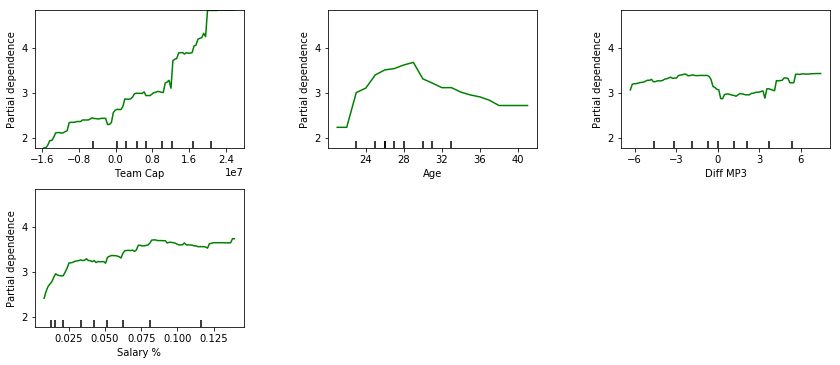

In [95]:
fig , axs = plot_partial_dependence(gbc0, X0_train.values, [0,2,22,27],
                                   feature_names=X0_train.columns,
                                    figsize=(13,8))

#plt.savefig('img/cluster0_important_depend.png')

In [242]:
params1 = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
          'n_estimators':[25,50,75,100,150,200,250,300,350],
          'max_depth':[2,5,8,10,12,15],
          'max_features':[None,'sqrt'],
          'subsample':[0.25,0.5,0.75,1]}
gbc1 = GradientBoostingClassifier()
gs1 = GridSearchCV(gbc1,param_grid=params1,scoring='roc_auc',cv=3).fit(X1_train,y1_train)
gs1.best_params_

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.005,
 'max_depth': 2,
 'max_features': None,
 'n_estimators': 200,
 'subsample': 1}

In [96]:
gbc1 = GradientBoostingClassifier(learning_rate=0.005,max_depth=2,max_features='sqrt',n_estimators=200,subsample=0.75)
gbc1.fit(X1_train,y1_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.75, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [97]:
probs1 = gbc1.predict_proba(X1_test)[:, 1]

In [98]:
preds1 = get_preds(probs1,y1_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


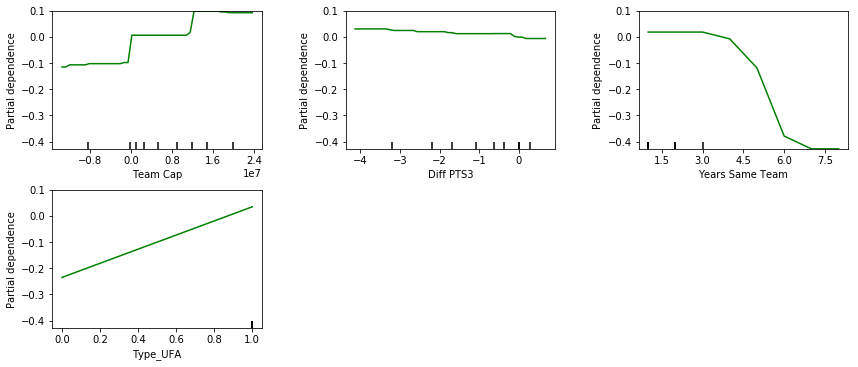

In [99]:
fig , axs = plot_partial_dependence(gbc1, X1_train.values, [0,23,25,28],
                                   feature_names=X1_train.columns,
                                    grid_resolution=50,figsize=(13,8))

#plt.savefig('img/cluster1_important_depend.png')

In [23]:
params2 = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
          'n_estimators':[25,50,75,100,150,200,250,300,350],
          'max_depth':[2,5,8,10,12,15],
          'max_features':[None,'sqrt'],
          'subsample':[0.25,0.5,0.75,1]}
gbc2 = GradientBoostingClassifier()
gs2 = GridSearchCV(gbc2,param_grid=params2,scoring='roc_auc',cv=3).fit(X2_train,y2_train)
gs2.best_params_

KeyboardInterrupt: 

In [115]:
def model_zero_fit(X0_train,y0_train):
    '''
    Fits model for cluster 0.
    INPUT: X_train and y_train
    OUTPUT: None
    '''
    model = GradientBoostingClassifier(learning_rate=0.1,max_depth=12,max_features='sqrt',n_estimators=250,subsample=0.75)
    model.fit(X_train,y_train)
def model_one_fit(X1_train,y1_train):
    '''
    Fits model for cluster 1.
    INPUT: X_train and y_train
    OUTPUT: None
    '''
    model1 = GradientBoostingClassifier(learning_rate=0.005,max_depth=2,max_features='sqrt',n_estimators=20,subsample=0.75)
    model1.fit(X1_train,y1_train)
def model_two_fit(X_train,y_train):
    '''
    Fits model for cluster 2.
    INPUT: X_train and y_train
    OUTPUT: None
    '''
    model2 = GradientBoostingClassifier(learning_rate=0.005,max_depth=15,max_features='sqrt',n_estimators=250,subsample=0.75)
    model2.fit(X2_train,y2_train)
def final_model(X,y):
    nba_reduced,labels = scale_and_split(X,y)
    group0, y0 = split_groups(X_1,y_1,labels,0)
    X0_train, X0_test, y0_train, y0_test = train_test_split(group0,y0)
    group1, y1 = split_groups(X_1,y_1,labels,1)
    X1_train, X1_test, y1_train, y1_test = train_test_split(group1,y1)
    group2, y2 = split_groups(X_1,y_1,labels,2)
    X2_train, X2_test, y2_train, y2_test = train_test_split(group2,y2)
    model_zero_fit(X0_train,y0_train)
    model_one_fit(X1_train,y1_train)
    model_two_fit(X2_train,y2_train)
    probs = model.predict_proba(X0_test)
    probs1 = model1.predict_proba(X1_test)
    probs2 = model2.predict_proba(X2_test)
    preds = get_preds(probs,y0_test)
    preds1 = get_preds(probs1,y1_test)
    preds2 = get_preds(probs2,y2_test)
    return preds,preds1,preds2

    
    

In [100]:
gbc2 = GradientBoostingClassifier(learning_rate=0.005,max_depth=15,max_features='sqrt',n_estimators=250,subsample=0.75)
gbc2.fit(X2_train,y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=15,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.75, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [101]:
probs2 = gbc1.predict_proba(X2_test)[:, 1]

In [102]:
preds2 = get_preds(probs2,y2_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
thresh0 = get_threshold(probs0,y0_test)
pred0_long = (probs0 > thresh0).astype(int)
confusion_matrix(y0_test,pred0_long)

array([[10, 18],
       [ 7, 84]])

In [104]:
thresh1 = get_threshold(probs1,y1_test)
pred1_long = (probs1 > thresh1).astype(int)
confusion_matrix(y1_test,pred1_long)

array([[ 11,  22],
       [  5, 113]])

In [105]:
thresh2 = get_threshold(probs2,y2_test)
pred2_long = (probs2 > thresh2).astype(int)
confusion_matrix(y2_test,pred2_long)

array([[ 5, 15],
       [ 1, 29]])

In [ ]:
roc_auc_score()

In [17]:
29+113+84+5+11+10

252

In [18]:
252/(252+1+15+5+22+7+18)

0.7875

In [106]:
f1_score(y0_test,pred0_long)

0.8704663212435233

In [107]:
tn, fp, fn, tp = confusion_matrix(y0_test,pred0_long).ravel() + confusion_matrix(y1_test,pred1_long).ravel() + confusion_matrix(y2_test,pred2_long).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + tn)
2 * (precision*recall)/(precision+recall)

0.848030018761726

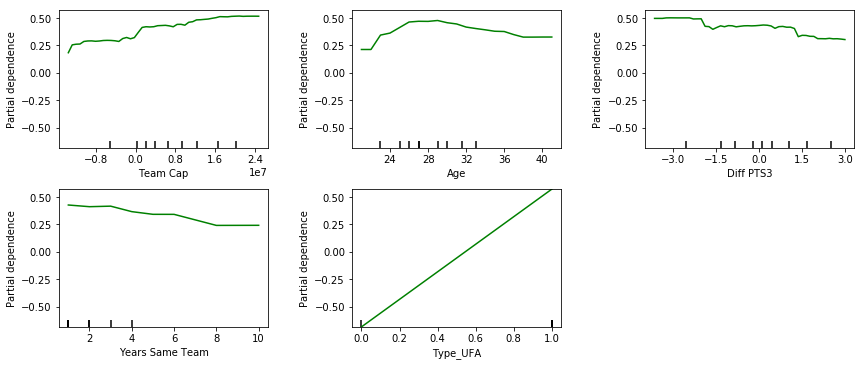

In [56]:
fig , axs = plot_partial_dependence(gbc2, X2_train.values, [0,2,23,25,28],
                                   feature_names=X2_train.columns,
                                    grid_resolution=50,figsize=(13,8))

plt.savefig('img/cluster2_important_depend.png')

In [18]:
group0.describe()

,Team Cap,Year,Age,G,GS,MP,FG,FGA,3P,3PA,...,Years Same Team,Salary,Salary %,Type_UFA,Pos._F,Pos._G,Pos._PF,Pos._PG,Pos._SF,Pos._SG
count,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,...,200.000000,2.000000e+02,200.000000,200.000000,200.0,200.0,200.000000,200.000000,200.000000,200.000000
mean,6.886649e+06,2014.605000,28.305000,67.825000,53.820000,30.939000,5.584500,12.177000,1.161500,3.20850,...,2.890000,9.862195e+06,0.143006,0.825000,0.0,0.0,0.175000,0.220000,0.180000,0.265000
std,1.049624e+07,2.163882,4.019047,14.795231,25.461324,3.594745,1.290168,2.655471,0.830976,2.12096,...,2.099988,6.588024e+06,0.091042,0.380921,0.0,0.0,0.380921,0.415286,0.385152,0.442441
min,-2.228839e+07,2011.000000,22.000000,2.000000,0.000000,20.400000,3.300000,5.500000,0.000000,0.00000,...,1.000000,4.802800e+04,0.000762,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.517185e+05,2013.000000,25.000000,63.000000,39.750000,28.200000,4.700000,10.475000,0.500000,1.47500,...,1.000000,4.000000e+06,0.058440,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,6.868932e+06,2015.000000,28.000000,72.500000,62.000000,31.450000,5.300000,11.900000,1.100000,3.40000,...,2.000000,8.860000e+06,0.133101,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,1.300700e+07,2016.000000,30.000000,78.000000,75.000000,33.400000,6.200000,13.700000,1.800000,4.90000,...,4.000000,1.448256e+07,0.219995,1.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000
max,3.597294e+07,2018.000000,39.000000,83.000000,82.000000,38.700000,10.500000,19.900000,4.100000,10.00000,...,10.000000,3.328571e+07,0.387215,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [19]:
group1.describe()

,Team Cap,Year,Age,G,GS,MP,FG,FGA,3P,3PA,...,Years Same Team,Salary,Salary %,Type_UFA,Pos._F,Pos._G,Pos._PF,Pos._PG,Pos._SF,Pos._SG
count,5.980000e+02,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,...,598.000000,5.980000e+02,598.000000,598.000000,598.0,598.000000,598.000000,598.000000,598.000000,598.000000
mean,6.706315e+06,2014.319398,27.702341,34.642140,3.869565,11.002676,1.217057,2.898829,0.280100,0.868562,...,1.561873,1.949408e+06,0.029208,0.916388,0.0,0.005017,0.257525,0.193980,0.180602,0.182274
std,1.150477e+07,2.311574,4.509624,20.221281,8.165153,4.151183,0.594709,1.330438,0.341573,0.915682,...,1.121744,2.353088e+06,0.036620,0.277037,0.0,0.070710,0.437637,0.395744,0.385010,0.386394
min,-3.118008e+07,2011.000000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.785900e+04,0.000480,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.510295e+05,2012.000000,24.000000,17.000000,0.000000,7.800000,0.725000,1.825000,0.000000,0.000000,...,1.000000,6.548565e+05,0.009337,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.554228e+06,2014.000000,27.000000,33.500000,1.000000,11.000000,1.200000,2.900000,0.100000,0.600000,...,1.000000,1.229255e+06,0.018426,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.332185e+07,2016.000000,31.000000,51.000000,4.000000,14.200000,1.600000,3.900000,0.500000,1.400000,...,2.000000,2.328652e+06,0.033391,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
max,4.368104e+07,2018.000000,40.000000,82.000000,82.000000,21.900000,3.200000,7.400000,2.400000,5.000000,...,10.000000,1.926931e+07,0.331978,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


Group 1: Plays more games but dont start as often.

In [20]:
group2.describe()

,Team Cap,Year,Age,G,GS,MP,FG,FGA,3P,3PA,...,Years Same Team,Salary,Salary %,Type_UFA,Pos._F,Pos._G,Pos._PF,Pos._PG,Pos._SF,Pos._SG
count,4.810000e+02,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,4.810000e+02,481.000000,481.000000,481.0,481.000000,481.000000,481.000000,481.000000,481.000000
mean,7.195889e+06,2014.659044,28.004158,61.619543,20.690229,21.701871,3.068191,6.956757,0.773181,2.174844,...,1.800416,3.766700e+06,0.055399,0.871102,0.0,0.006237,0.230769,0.216216,0.170478,0.253638
std,1.159587e+07,2.193781,3.879968,18.701681,20.790765,4.168020,0.782548,1.793937,0.638625,1.652249,...,1.197950,3.374494e+06,0.051479,0.335436,0.0,0.078810,0.421764,0.412092,0.376444,0.435546
min,-3.118008e+07,2011.000000,21.000000,1.000000,0.000000,11.600000,1.000000,2.900000,0.000000,0.000000,...,1.000000,2.402200e+04,0.000255,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.479600e+05,2013.000000,25.000000,54.000000,5.000000,18.700000,2.500000,5.600000,0.100000,0.500000,...,1.000000,1.272279e+06,0.017163,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.621875e+06,2015.000000,27.000000,66.000000,14.000000,21.600000,3.000000,6.700000,0.700000,2.200000,...,1.000000,2.911231e+06,0.042583,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.408714e+07,2016.000000,31.000000,76.000000,30.000000,24.900000,3.600000,8.200000,1.200000,3.400000,...,2.000000,5.138430e+06,0.070739,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.597294e+07,2018.000000,41.000000,82.000000,81.000000,35.000000,5.600000,12.600000,2.900000,7.500000,...,10.000000,2.145980e+07,0.369716,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


Group 2: Starts and plays a lot of games.

In [116]:
fa_this_year['Playoffs'] = 1

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_model()

In [66]:
scaler = StandardScaler()
scaler.fit(fa_this_year)
X_this_year = scaler.transform(fa_this_year)
pca = PCA(n_components=3).fit(X_this_year)
this_year_reduced = pca.transform(X_this_year)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
this_year_labels = km.predict(this_year_reduced)

In [84]:
fa_this_year.drop('Churn',axis=1,inplace=True)
this_year_group0 = fa_this_year[this_year_labels==0]
this_year_group1 = fa_this_year[this_year_labels==1]
this_year_group2 = fa_this_year[this_year_labels==2]

/Users/MSteele/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [98]:
this_year_proba0 = gbc0.predict_proba(this_year_group0)
this_year_proba1 = gbc1.predict_proba(this_year_group1)
this_year_proba2 = gbc2.predict_proba(this_year_group2)

In [88]:
this_year_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [94]:
group0_churn = this_year_group0[this_year_pred0==1].index
group0_stay = this_year_group0[this_year_pred0==0].index
group1_churn = this_year_group1[this_year_pred1==1].index
group1_stay = this_year_group1[this_year_pred1==0].index
group2_churn = this_year_group2[this_year_pred2==1].index
group2_stay = this_year_group2[this_year_pred2==0].index

In [95]:
group2_churn

Index(['Marc Gasol', 'Thaddeus Young', 'DeAndre Jordan', 'Hassan Whiteside',
       'Dwight Howard', 'Jeff Teague', 'Paul Millsap', 'Trevor Ariza',
       'Jimmy Butler', 'Enes Kanter', 'Khris Middleton', 'Al Horford',
       'Harrison Barnes', 'Bojan Bogdanovic', 'Rudy Gay', 'Jabari Parker',
       'Jonas Valanciunas', 'Ricky Rubio', 'Nikola Vucevic', 'Kemba Walker'],
      dtype='object')

In [96]:
group2_stay

Index(['Kawhi Leonard', 'Tobias Harris', 'Kevin Durant', 'Julius Randle',
       'DeMarcus Cousins', 'Kyrie Irving', 'Klay Thompson', 'Jeremy Lamb',
       'Lauri Markkanen', 'Willie Cauley-Stein', 'Donovan Mitchell'],
      dtype='object')

In [101]:
this_year_proba2[:,1]

array([0.89031984, 0.99813835, 0.99894966, 0.63962257, 0.99960664,
       0.99980349, 0.98947735, 0.99975443, 0.01919741, 0.99865604,
       0.68540676, 0.99243569, 0.28161064, 0.97179414, 0.8033594 ,
       0.11837029, 0.99276439, 0.99889382, 0.90132956, 0.22652457,
       0.43963865, 0.00198095, 0.00123932, 0.69239213, 0.99978252,
       0.99352773, 0.99498289, 0.31640403, 0.00135847, 0.00275603,
       0.01051189])

In [104]:
this_year_group2.index

Index(['Marc Gasol', 'Thaddeus Young', 'DeAndre Jordan', 'Hassan Whiteside',
       'Dwight Howard', 'Jeff Teague', 'Paul Millsap', 'Trevor Ariza',
       'Kawhi Leonard', 'Jimmy Butler', 'Enes Kanter', 'Khris Middleton',
       'Tobias Harris', 'Al Horford', 'Harrison Barnes', 'Kevin Durant',
       'Bojan Bogdanovic', 'Rudy Gay', 'Jabari Parker', 'Julius Randle',
       'DeMarcus Cousins', 'Kyrie Irving', 'Klay Thompson',
       'Jonas Valanciunas', 'Ricky Rubio', 'Nikola Vucevic', 'Kemba Walker',
       'Jeremy Lamb', 'Lauri Markkanen', 'Willie Cauley-Stein',
       'Donovan Mitchell'],
      dtype='object')

In [240]:
pd.concat([pd.Series(this_year_group2.index),pd.Series(this_year_proba2[:,1]])

NameError: name 'this_year_group2' is not defined

In [110]:
pd.concat([pd.Series(this_year_group1.index),pd.Series(this_year_proba1[:,1])],axis=1)

,0,1
0,Wilson Chandler,0.712928
1,Jose Barea,0.798652
2,Vince Carter,0.764245
3,Jeff Green,0.801645
4,DeMarre Carroll,0.790751
5,Jamal Crawford,0.790751
6,Ishmael Smith,0.814165
7,JaVale McGee,0.698092
8,Goran Dragic,0.805122
9,Jeremy Lin,0.806725


In [111]:
pd.concat([pd.Series(this_year_group0.index),pd.Series(this_year_proba0[:,1])],axis=1)

,0,1
0,Tyson Chandler,0.896521
1,Luc Mbah a Moute,0.858248
2,Jonas Jerebko,0.859769
3,Corey Brewer,0.771612
4,Dante Cunningham,0.884255
5,Raymond Felton,0.841475
6,Jodie Meeks,0.878802
7,Anthony Tolliver,0.896521
8,Jose Calderon,0.847411
9,Zaza Pachulia,0.846885


In [289]:
sum(y2_train)/len(y2_train)

0.5581395348837209

In [296]:
confusion_matrix(y2_test,pred2_long)

array([[ 9, 11],
       [ 4, 20]])

In [297]:
29/(29+15)

0.6590909090909091

In [290]:
sum(y1_train)/len(y1_train)

0.7282913165266106

In [294]:
confusion_matrix(y1_test,pred1_long)

array([[ 0, 30],
       [ 0, 89]])

In [295]:
89/(89+30)

0.7478991596638656

In [291]:
sum(y0_train)/len(y0_train)

0.8389830508474576

In [327]:
confusion_matrix(y0_test,pred0_long)

ValueError: Found input variables with inconsistent numbers of samples: [132, 158]

In [293]:
132/(132+26)

0.8354430379746836

In [325]:
132/(132)

1.0

In [326]:
2*(0.8354)/(1.8354)

0.9103192764519996

In [68]:
(.87-0.86)/0.86

0.011627906976744196

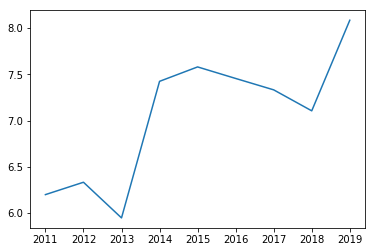

In [112]:
plt.plot(final_data.groupby('Year').mean()['PTS'])

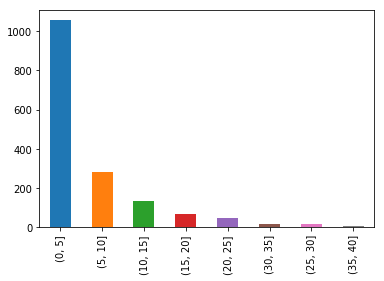

In [55]:
pd.cut(final_data['Salary %']*100,[0,5,10,15,20,25,30,35,40]).value_counts().plot('bar')
plt.savefig('img/salary%_bin.png')

In [157]:
pd.cut(final_data['Diff MP3'],[-20,0,20]).value_counts()

(-20, 0]    1077
(0, 20]      557
Name: Diff MP3, dtype: int64

In [54]:
final_data['Salary %'].value_counts()

0.008159    32
0.023296    32
0.000758    30
0.013131    23
0.000780    20
0.014720    18
0.012072    12
0.013246    12
0.021178    12
0.021073    11
0.023500    11
0.021417    10
0.014848     9
0.014513     9
0.022968     9
0.015166     8
0.013530     8
0.012947     8
0.019749     8
0.017102     8
0.051685     8
0.008045     7
0.015070     7
0.015557     7
0.016482     7
0.068913     7
0.015383     7
0.015779     7
0.060299     7
0.043071     7
            ..
0.005223     1
0.028571     1
0.033848     1
0.013493     1
0.005298     1
0.046119     1
0.319419     1
0.096429     1
0.039625     1
0.092319     1
0.007801     1
0.106411     1
0.146560     1
0.080732     1
0.049869     1
0.115430     1
0.007051     1
0.020219     1
0.173473     1
0.036428     1
0.063673     1
0.017228     1
0.110204     1
0.032841     1
0.018736     1
0.040002     1
0.243905     1
0.040679     1
0.055334     1
0.364148     1
Name: Salary %, Length: 1108, dtype: int64

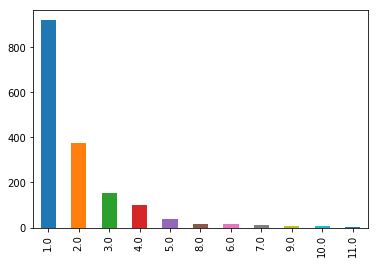

In [202]:
final_data['Years Same Team'].value_counts().plot('bar')

,Pos.,Team Cap,Type,Year,Age,G,GS,MP,FG,FGA,...,PF,PTS,Playoffs,Diff MP3,Diff PTS3,Traded,Years Same Team,Salary,Salary %,Churn
Marc Gasol,C,2348727,RFA,2011,26.0,81.0,81.0,31.9,4.5,8.5,...,3.3,11.7,1.0,-0.900000,-1.033333,0.0,3.0,3480000.0,0.059955,0
Marc Gasol,C,1357957,UFA,2015,30.0,81.0,81.0,33.2,6.5,13.2,...,2.6,17.4,1.0,-0.666667,2.033333,0.0,7.0,15829688.0,0.251006,0
Marc Gasol,C,-76191,UFA,2019,34.0,76.0,69.0,30.9,5.1,11.3,...,2.8,13.8,NaN,-1.800000,-3.033333,1.0,1.0,24119025.0,0.236765,1
Tyson Chandler,C,-4903420,UFA,2011,28.0,74.0,74.0,27.8,3.6,5.5,...,3.2,10.1,1.0,0.233333,1.633333,0.0,1.0,12600000.0,0.217077,1
Tyson Chandler,C,11643139,UFA,2015,32.0,75.0,75.0,30.5,3.9,5.9,...,2.3,10.3,1.0,-0.666667,0.500000,0.0,2.0,14596888.0,0.231458,1
Tyson Chandler,C,64772353,UFA,2019,36.0,55.0,6.0,15.9,1.1,1.8,...,2.0,3.1,NaN,-6.933333,-2.900000,1.0,1.0,13585000.0,0.133358,1
Thaddeus Young,PF,5539775,RFA,2011,22.0,82.0,1.0,26.0,5.6,10.3,...,2.1,12.7,1.0,-4.800000,-1.233333,0.0,3.0,2901241.0,0.049983,0
Thaddeus Young,PF,4236153,UFA,2015,26.0,76.0,68.0,32.0,5.9,12.7,...,2.3,14.1,0.0,-1.666667,-1.500000,1.0,1.0,9160870.0,0.145261,0
Thaddeus Young,PF,71834149,UFA,2019,30.0,79.0,79.0,30.8,5.4,10.4,...,2.4,12.6,NaN,-0.266667,0.800000,0.0,3.0,13764045.0,0.135115,1
DeAndre Jordan,C,733111,RFA,2011,22.0,80.0,66.0,25.6,2.9,4.3,...,3.2,7.1,0.0,6.833333,1.700000,0.0,3.0,854389.0,0.014720,0


In [184]:
X_1['labels'] = labels
X_1['Churn'] = y_1

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


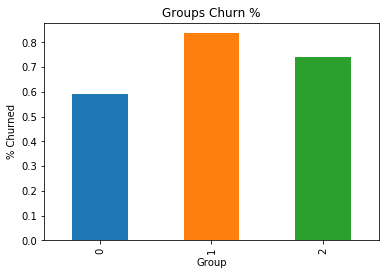

In [193]:
X_1.groupby(labels).mean()['Churn'].plot('bar')
plt.title('Groups Churn %')
plt.xlabel('Group')
plt.ylabel('% Churned')
plt.savefig('img/group_churn.png')

In [234]:
group0['Churn'] = y0

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


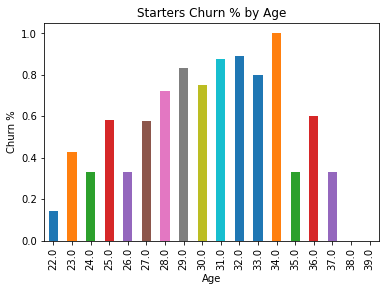

In [238]:
group0.groupby('Age').mean()['Churn'].plot('bar')
plt.title('Starters Churn % by Age')
plt.ylabel('Churn %')
plt.savefig('img/churn_by_age.png')

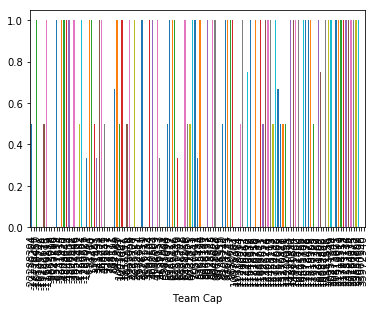

In [239]:
group0.groupby('Team Cap').mean()['Churn'].plot('bar')

In [57]:
np.sqrt(35)

5.916079783099616

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
total_cap_dict = {'2010':57700000,'2011':58044000,'2012':58044000,'2013':58044000,'2014':58679000,'2015':63065000
            ,'2016':70000000,'2017':94143000,'2018':99093000,'2019':101869000,'2020':109000000}

Text(0.5, 0, 'Salary Cap')

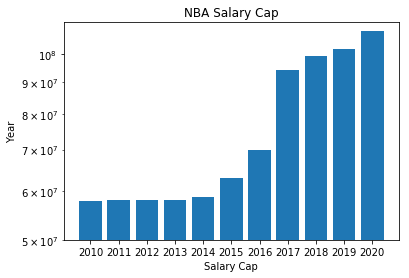

In [21]:
plt.bar(total_cap_dict.keys(),total_cap_dict.values())
plt.yscale('log')
plt.ylim(bottom=50000000)
plt.title('NBA Salary Cap')
plt.ylabel('Year')
plt.xlabel('Salary Cap')

In [23]:
total_cap_dict.keys()

dict_keys(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  """


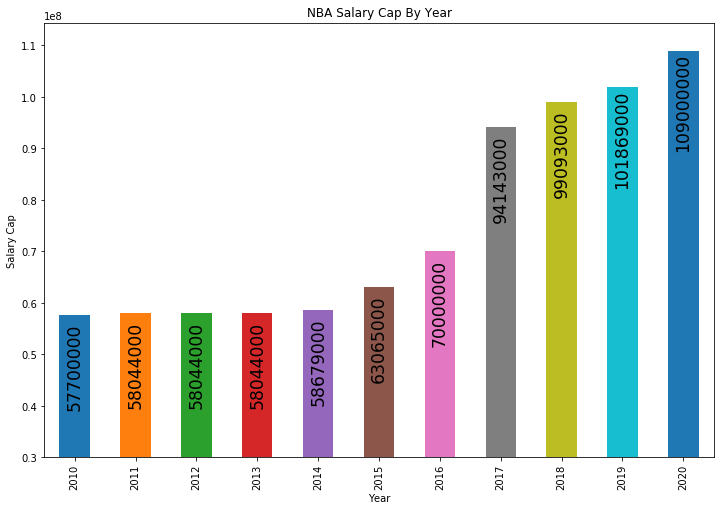

In [72]:
salaries = [57700000, 58044000, 58044000, 58044000, 58679000, 63065000, 70000000, 94143000, 99093000, 101869000, 109000000]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
series = pd.Series.from_array(salaries)

x_labels = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = series.plot(kind='bar')
ax.set_title('NBA Salary Cap By Year')
ax.set_xlabel('Year')
ax.set_ylabel('Salary Cap')
ax.set_ylim(bottom=30000000)
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make some labels.
labels = [salaries[i] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height - 10000000, label,
            ha='center', va='center',fontsize='xx-large',rotation='vertical')
plt.savefig('img/salary_cap_change.png')

In [109]:
def profit_curve(cost_benefit, predicted_probs, labels):
    """Function to calculate list of profits based on supplied cost-benefit
    matrix and prediced probabilities of data points and thier true labels.

    Parameters
    ----------
    cost_benefit    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    predicted_probs : ndarray - 1D, predicted probability for each datapoint
                                    in labels, in range [0, 1]
    labels          : ndarray - 1D, true label of datapoints, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(labels))
    # Make sure that 1 is going to be one of our thresholds
    maybe_one = [] if 1 in predicted_probs else [1] 
    thresholds = maybe_one + sorted(predicted_probs, reverse=True)
    profits = []
    for threshold in thresholds:
        y_predict = predicted_probs >= threshold
        confusion_matrix = standard_confusion_matrix(labels, y_predict)
        threshold_profit = np.sum(confusion_matrix * cost_benefit) / n_obs
        profits.append(threshold_profit)
    return np.array(profits), np.array(thresholds)
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

In [166]:
cost_benefit0 = np.array([[1, -2], [0, 0]])
cost_benefit1 = np.array([[1, -1], [0, 0]])
cost_benefit2 = np.array([[1, -3], [0, 0]])

In [167]:
profit0,threshold0 = profit_curve(cost_benefit0,probs0,y0_test)

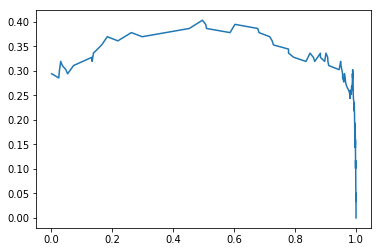

In [168]:
plt.plot(threshold0,profit0)

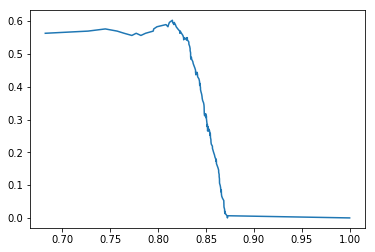

In [169]:
profit1,threshold1 = profit_curve(cost_benefit1,probs1,y1_test)
plt.plot(threshold1,profit1)

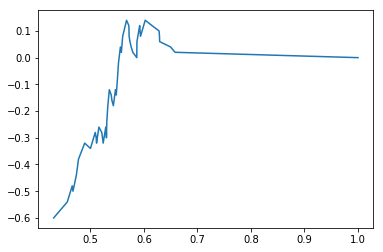

In [170]:
profit2,threshold2 = profit_curve(cost_benefit2,probs2,y2_test)
plt.plot(threshold2,profit2)

In [20]:
group0['Churn'] = y0
group0.groupby('Year').mean()['Churn']

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Year
2011    0.723404
2012    0.687500
2013    0.774194
2014    0.711538
2015    0.650794
2016    0.791667
2017    0.696429
2018    0.783333
Name: Churn, dtype: float64

In [15]:
y2

Darrun Hilliard          1
Lester Hudson            1
Craig Smith              1
James Anderson           1
Aron Baynes              0
Jason Kapono             1
ETwaun Moore             1
Nick Collison            1
Jabari Bird              0
Hedo Turkoglu            1
Darius Johnson-Odom      0
Joe Smith                1
Sam Young                1
Beno Udrih               0
Larry Owens              1
Damien Inglis            1
Salah Mejri              0
Ronnie Brewer            1
Armon Johnson            1
Ronny Turiaf             1
James White              1
Hamed Haddadi            0
Vladimir Radmanovic      1
Jonny Flynn              1
Briante Weber            1
Anthony Tolliver         1
Nik Stauskas             1
Chris Kaman              1
Dominique Jones          1
Tyrus Thomas             1
                        ..
Mickell Gladness         1
Boris Diaw               1
DeMarre Carroll          1
Josh Harrellson          1
Jahlil Okafor            1
Greg Smith               1
J

In [15]:
.785

1075

In [ ]:
.755

In [21]:
(.785-.755)/.755

0.03973509933774838